# Final Model for Twitter Generation Classification

Input: 80-20 train/test split with tweets, generation label, generated metadata features, and features generated from a fine-tuned BERT model.

In [0]:
import random
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
!pip install catboost
from catboost import CatBoostClassifier
from google.colab import files
import io

In [0]:
uploaded = files.upload()

df_train = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))
df_train = df_train.drop('Unnamed: 0', axis=1).reset_index(drop=True)

df_test = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')))
df_test = df_test.drop('Unnamed: 0', axis=1).reset_index(drop=True)

In [0]:
# Generate data and label DF's, drop text features
X_train = df_train.copy(deep=True).drop('age_group', axis=1).drop("handle", axis=1).drop('hashtags', axis=1).drop('tweets_text', axis=1)
Y_train = df_train.age_group.values
X_test = df_test.copy(deep=True).drop('age_group', axis=1).drop("handle", axis=1).drop('hashtags', axis=1).drop('tweets_text', axis=1)
Y_test = df_test.age_group.values
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

We keep the 18 most important BERT embeddings, which we found by training gradient boosting and tree-based models and analyzing feature importance. We remove other embeddings since too much data will take too long to train and not perform as well.

In [6]:
important_embeddings = {547, 548, 611, 448, 335, 561, 727, 274, 110, 124, 355, 438, 423, 629, 354, 165, 160, 518}
for i in range(768):
    if i not in important_embeddings:
        name = 'embed' + str(i)
        X_train = X_train.drop(name, axis=1)
        X_test = X_test.drop(name, axis=1)

print(X_train.head())

   followers  following  ...  slang_count  pct_valid_words
0     1634.0     1091.0  ...          0.0         0.725664
1   733157.0       66.0  ...          0.0         0.875000
2    14396.0       57.0  ...          0.0         0.951282
3      465.0      389.0  ...          0.0         0.913978
4       32.0       27.0  ...          0.0         0.903780

[5 rows x 46 columns]


This CatBoost with tuned hyperparameters achieved the best performance out of everything else we tried.

In [10]:
model = CatBoostClassifier(iterations=4400,
                           learning_rate=.02,
                           depth=4,
                           loss_function='MultiClass',
                           verbose=False)
model.fit(X_train, Y_train)
print("Accuracy:", model.score(X_test, Y_test))
predictions = model.predict(X_test)

Accuracy: 0.6


We show the feature importances to show what CatBoost deemed important for our model:

Top 15 features:
Feature: Logit3                                   Importance: 5.62
Feature: followers                                Importance: 4.7758
Feature: Logit0                                   Importance: 3.4684
Feature: following                                Importance: 3.3544
Feature: embed160                                 Importance: 3.2294
Feature: embed547                                 Importance: 3.0207
Feature: embed165                                 Importance: 2.7158
Feature: avg_timedelta_hrs                        Importance: 2.7157
Feature: follower_following_ratio                 Importance: 2.6424
Feature: embed438                                 Importance: 2.6402
Feature: embed335                                 Importance: 2.6128
Feature: embed548                                 Importance: 2.6006
Feature: avg_word_count                           Importance: 2.5709
Feature: embed274                                 Importance: 2.5454
Feature: embed611  

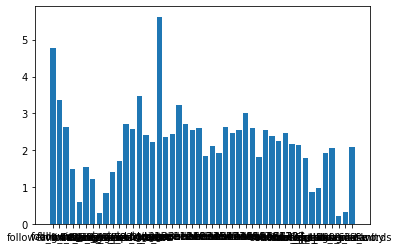

In [13]:
cat_feat_imps = model.get_feature_importance()
importances = list(cat_feat_imps)
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(X_train.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print top 10
print("Top 15 features:")
[print('Feature: {:40} Importance: {}'.format(*pair)) for pair in feature_importances[0:15]]

# Plot
plt.bar(X_train.columns, importances)
plt.show()

Most of the model's most important features seem to be those generated by our fine-tuned BERT model. However, the BERT classifier on its own only achieved a 54% accuracy, so ensembling with the metadata and sentence embeddings definitely helped our performance.

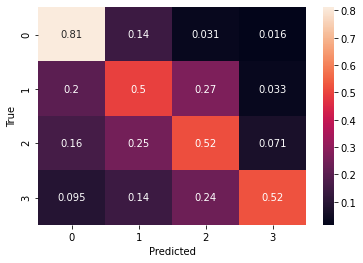

In [14]:
# Confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sn

cm = confusion_matrix(Y_test, predictions, normalize='true')
df_cm = pd.DataFrame(cm, range(4), range(4))
sn.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

As a benchmark, we train a dummy classifier based on the output distribution of our data. We see that our model does over twice as well as this.

In [17]:
from sklearn.dummy import DummyClassifier

# Dummy as benchmark
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, Y_train)
print(dummy_clf.score(X_test, Y_test))

0.26823529411764707


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
